## Условие задачи

Используя схему бегущего счета и итерационные методы, решить задачу для квазилинейного уравнением переноса:

$\left\{\begin{aligned}
\frac{\partial u}{\partial t} - u\frac{\partial u}{\partial x}  = 0,\ ~ -1 \leq x < 0\\
u(x,0)= 2 - \frac{4}{\pi} arctg(x+2) \\
u(0,t) = (2-\frac{4}{\pi} arctg(2)) e^{-t} \\ 
\end{aligned}\\
\right. $

###### Исследование характеристик
В точках пересечения проекций его характеристик, решение будет разрывным. Посмотрим как будут вести себя проекции характеристик в заданных областях. Уравнение характеристик будет иметь вид:

$\frac{~~dt}{1}= - \frac{dx}{u} = \frac{du}{0}$

Отсюда

$\left\{\begin{aligned}
u = u(x_{0},t_{0})= const \\
t-t_{0} = - \frac{1}{u} (x-x_{0}) \\ 
\end{aligned}\\
\right. $

Воспользуемся начальным и граничным условиями для получения двух семейств кривых:
    
1) $~~t_0=0: ~~~~~ t= - \frac{1}{2 - \frac{4}{\pi} arctg(x_0+2)}(x-x_0)$

2) $~~x_0=0: ~~~~~ t= - \frac{1}{(2 - \frac{4}{\pi} arctg(2)) e^{-t_0}} x +t_0$


Импортируем необходимые библиотеки.

In [6]:
import math 
from math import *
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d

Определим функции характеристик через массивы, где итерирование будет идти по соответствующему неизвестному параметру: $x_0$ или $t_0$  . Здесь $x_0$ и $t_0$ взяты с определенными шагами c помощью np.arange.

In [7]:
def ch1(x):
    return [ - ((1/(2 - (4/math.pi)*math.atan(x0+2)))*(x-x0)) for x0 in np.arange(-1, 0.1, .1)]

def ch2(x):
    return [(-1/((2-(4/math.pi)*math.atan(2))*exp(-t0)) * (x) + t0) for t0 in np.arange(-1, 0.1, .1)]

 Создадим массив значений по $x$ от $0$ до $1$ с определенным шагом и соответсвущие массивы для функций с итерированием уже по $x$. 

In [8]:
x_list = np.arange(-1, 0.1, .1)

ch1_list = [ch1(x) for x in x_list]
ch2_list = [ch2(x) for x in x_list]

#ch2_list

Построим соответствующие графики.

<IPython.core.display.Javascript object>


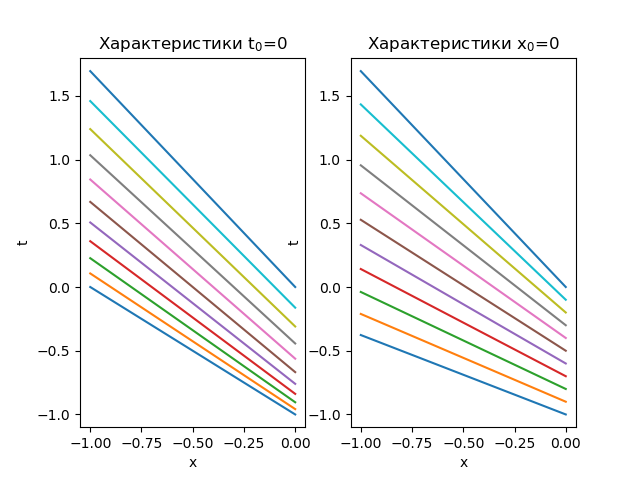

In [9]:
%matplotlib notebook

plt.subplot(1, 2, 1)
plt.ylim(-1.1,1.8)
plt.xlim(-1.05,0.05)
plt.plot(x_list, ch1_list) 
plt.title('Характеристики t$_{0}$=0',loc='center')
plt.ylabel('t')
plt.xlabel('x')
plt.subplot(1, 2, 2)
plt.ylim(-1.1,1.8)
plt.xlim(-1.05,0.05)
plt.plot(x_list, ch2_list) 
plt.title('Характеристики x$_{0}$=0',loc='center')
plt.ylabel('t')
plt.xlabel('x')


plt.show()

Как видим, в заданных областях пересечений нет. Следовательно, нет так называемого опрокидывания волны, и во всей области решение будет представимо через разностную схему.

# Численное решение

## Сетка
Введем в области $\Omega=\{(x,t):0 < x \leq 1,~~0<t<T\} $ сетку с шагом $h_x$ по $x$ и шагом $h_t$ по $t$:
\begin{eqnarray}
\omega_{h_x, ~ h_t}=\begin{cases}
x_n=n\cdot h_x, ~~h_x=\frac{1}{N}, ~~n=\overline{0, N}\\
t_m=m\cdot h_t, ~~h_t=\frac{1}{M}, ~~m=\overline{0, M}
\end{cases}
\end{eqnarray}

На $\omega_{h_x, ~ h_t}$ будем рассматривать сеточную функцию $y^m_{n}=u(x_n,t_m)$

## Шаблон

Перепишем исходное уравнение, приведя его к дивергентному виду: 

$$\frac{\partial u}{\partial t} - \frac{\partial (u^2/2)}{\partial x} = 0 $$

Для рассматриваемой задачи будем использовать [четырехточечный шаблон](http://math.phys.msu.ru/data/374/tema5.pdf). Он безусловно устойчив и аппроксимирует задачу как $ O({h_x}^2 + {h_t}^2)$.
![Четырехточечный шаблон](4-dots.png "Четырехточечный шаблон")

Таким образом, разностная схема задачи имеет вид:

$$\frac{y^{m+1}_n - y^m_{n} + y^{m+1}_{n+1} - y^m_{n+1}}{2h_t} - \frac{(y^{m+1}_{n})^{2} - (y^{m}_{n})^{2} + (y^{m+1}_{n+1})^2 - (y^{m}_{n+1})^2}{2 * 2h_x}=0$$

Также начальное и граничное условия:

$$\left\{\begin{aligned} 
y^0_n= 2 - \frac{4}{\pi} arctg(n h_x+2)  \\
y^{m}_0 = (2-\frac{4}{\pi} arctg(2))  e^{-m h_t } 
\end{aligned}\\
\right. $$


## Cхема бегущего счета
Данную задачу будем решать при помощи схемы бегущего счета. Значение сеточной функции $ y^{m+1}_{n+1} $ неизвестно, но нам известны все значения, соответствующие начальному( $y^0_n$ ) и граничному( $y^{m}_0$ ) условиям. Таким образом, зная значения в трех соседних точках: $y^{0}_0, y^{0}_1, y^{1}_0$, мы можем численно найти значение в четвертой точке $y^{1}_1$. Зная это значение, мы можем найти по трем известным точкам либо $y^{2}_1$, либо $y^{1}_2$. И так далее, заполняя найденными значениями сетку.  

Также начальное и граничное условия:

$$\left\{\begin{aligned} 
y^0_n= 2 - \frac{4}{\pi} arctg(n h_x+2) \\
y^{m}_0 = (2-\frac{4}{\pi} arctg(2)) e^{-m h_t } 
\end{aligned}\\
\right. $$

Это неявное уравнение относительно $ y^{m+1}_{n+1} $. Будем решать его [итерационным методом Ньютона](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9D%D1%8C%D1%8E%D1%82%D0%BE%D0%BD%D0%B0).

$$ {y^{m+1}_{n+1}}^{(s+1)} = {y^{m+1}_{n+1}}^{(s)} - \frac{ f({y^{m+1}_{n+1}}^{(s)}) }  { f'({y^{m+1}_{n+1}}^{(s)}) } $$

До достижения заданной точности $ \epsilon $: $$ | {y^{m+1}_{n+1}}^{(s+1)} - {y^{m+1}_{n+1}}^{(s)} | \leq \epsilon $$

## Код

Зададим: $\epsilon$ - точность в методе Ньютона, $N$ - количество шагов по $x$, $М$ - количество шагов по $y$, а также границы нашей сетки. 

In [10]:
epsilon = 0.0001
N = 50; M = 50
T_begin = 0.; T_end = 1.
X_begin = -1.; X_end = 0.

Соответственно, элементарные шаги.

In [11]:
h_x=-(X_end - X_begin)/(N-1)
h_t=(T_end - T_begin)/(M-1)

Создадим двумерный массив размерами с нашу сетку($N{\times}M$), в ячейках которого будут храниться соответствующие искомые значения.

In [12]:
y=np.zeros((M,N))

Начнем заполнять его начальным и граничным значениями.

In [13]:
for n in np.arange(N):
        y[0][n] = (2 - (4. /math.pi) * math.atan(h_x * n + 2))

for m in np.arange(M):
        y[m][0] = (2 - (4./ math.pi) * math.atan(2)) * exp(-h_t * m)

# Разностная схема будет иметь вид:

## Схема Г (четырехточечная)

In [14]:
def F(m,n): 
    return (-((y[m][n]) ** 2 ) / 2.)

# сама разностная схема
def f(mp1, np1): 
    n = np1-1
    m = mp1-1
    return ( float(y[mp1][n]-y[m][n] + y[mp1][np1]-y[m][np1]) / (2.*h_t) + float(F(mp1, np1)-F(mp1,n) + F(m, np1)-F(m,n)) / (2.*h_x) )

def df(mp1,np1):
    return (1/(2.*h_t) - y[mp1][np1]/(2. * h_x))

Перейдем к методу Ньютона, пробегая по всей сетке.

In [15]:
for m in np.arange(M)[0:M-1]:
    for n in np.arange(N)[0:N-1]:
        eps = epsilon + 1; # > epsilon
        while eps > epsilon:
            ep = f(m+1, n+1) / float(df( m+1, n+1))
            y[m+1][n+1] = y[m+1][n+1] - ep
            eps = abs(ep)  

# Построим график решения.

<IPython.core.display.Javascript object>


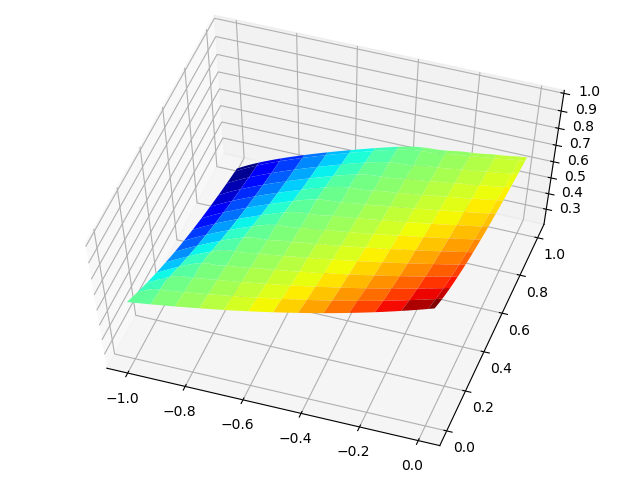

In [19]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

fig = pylab.figure()
axes = Axes3D(fig)

axes.plot_surface(X, T, y, rstride=4, cstride=4, cmap = cm.jet)

pylab.show()

pylab.savefig('sdgadfg.png')